<a href="https://colab.research.google.com/github/groda/big_data/blob/master/Run_Spark_on_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://github.com/groda/big_data"><div><img src="https://github.com/groda/big_data/blob/master/logo_bdb.png?raw=true" align=right width="90" alt="Logo Big Data for Beginners"></div></a>
# Run Apache Spark on Google Colab

This is a compact guide on how to set up Apache Spark on Google Colab.

A more detailed walkthrough of how to setup Spark on a single machine in *standalone mode* is presented in in [Hadoop: Setting up Spark Standalone on Google Colab](https://github.com/groda/big_data/blob/master/Hadoop_Setting_up_Spark_Standalone_on_Google_Colab.ipynb).

## Setup Spark

Setup Apache Spark in 1️⃣ 2️⃣ 3️⃣ 4️⃣ steps (step 0️⃣ is the Java installation, which is skipped because Java is available in Google Colab).

The following code should also run on any Ubuntu machine or Docker container except for the Web servers links.

In [1]:
import requests
import subprocess
import os
import re
import socket
import shutil
import time
import sys

def run(cmd):
    # run a shell command
    try:
        # Run the command and capture stdout and stderr
        subprocess_output = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        # Access stdout (stderr redirected to stdout)
        stdout_result = subprocess_output.stdout.strip().splitlines()[-1]
        # Process the results as needed
        print(f'✅ {stdout_result}')
        return stdout_result
    except subprocess.CalledProcessError as e:
        # Handle the error if the command returns a non-zero exit code
        print(f"Command failed with return code {e.returncode}")
        print("stdout:", e.stdout)

def is_java_installed():
    return shutil.which("java")

def install_java():
    # Uncomment and modify the desired version
    # java_version= 'openjdk-11-jre-headless'
    # java_version= 'default-jre'
    # java_version= 'openjdk-17-jre-headless'
    # java_version= 'openjdk-18-jre-headless'
    java_version= 'openjdk-19-jre-headless'
    os.environ['JAVA_HOME'] = ' /usr/lib/jvm/java-19-openjdk-amd64'
    print(f"Java not found. Installing {java_version} ... (this might take a while)")
    try:
        cmd = f"apt install -y {java_version}"
        subprocess_output = subprocess.run(cmd, shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
        stdout_result = subprocess_output.stdout
        # Process the results as needed
        print(f'✅ Done installing Java {java_version}')
    except subprocess.CalledProcessError as e:
        # Handle the error if the command returns a non-zero exit code
        print(f"Command failed with return code {e.returncode}")
        print("stdout:", e.stdout)

print("\n0️⃣   Install Java if not available")
if is_java_installed():
    print("✅ Java is already installed.")
else:
    install_java()

print("\n1️⃣   Download and install Hadoop and Spark")
# URL for downloading Hadoop and Spark
SPARK_VERSION = "3.5.6"
HADOOP_SPARK_URL = "https://dlcdn.apache.org/spark/spark-" + SPARK_VERSION + \
                   "/spark-" + SPARK_VERSION + "-bin-hadoop3.tgz"
r = requests.head(HADOOP_SPARK_URL)
if r.status_code >= 200 and r.status_code < 400:
    print(f'✅ {HADOOP_SPARK_URL} was found')
else:
    SPARK_CDN = "https://dlcdn.apache.org/spark/"
    print(f'⚠️ {HADOOP_SPARK_URL} was NOT found. \nCheck for available Spark versions in {SPARK_CDN}')

# set some environment variables
os.environ['SPARK_HOME'] = os.path.join(os.getcwd(), os.path.splitext(os.path.basename(HADOOP_SPARK_URL))[0])
os.environ['PATH'] = ':'.join([os.path.join(os.environ['SPARK_HOME'], 'bin'), os.environ['PATH']])
os.environ['PATH'] = ':'.join([os.path.join(os.environ['SPARK_HOME'], 'sbin'), os.environ['PATH']])

# download Spark
# using --no-clobber option will prevent wget from downloading file if already present
# shell command: wget --no-clobber $HADOOP_SPARK_URL
cmd = f"wget --no-clobber {HADOOP_SPARK_URL}"
run(cmd)

# uncompress
try:
    # Run the command and capture stdout and stderr
    cmd = "([ -d $(basename {0}|sed 's/\.[^.]*$//') ] && echo -n 'Folder already exists') || (tar xzf $(basename {0}) && echo 'Uncompressed Spark distribution')"
    subprocess_output = subprocess.run(cmd.format(HADOOP_SPARK_URL), shell=True, check=True, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True)
    # Access stdout (stderr redirected to stdout)
    stdout_result = subprocess_output.stdout
    # Process the results as needed
    print(f'✅ {stdout_result}')

except subprocess.CalledProcessError as e:
    # Handle the error if the command returns a non-zero exit code
    print(f"Command failed with return code {e.returncode}")
    print("stdout:", e.stdout)


print("\n2️⃣   Start Spark engine")
# start master
# shell command: $SPARK_HOME/sbin/start-master.sh
cmd = os.path.join(os.environ['SPARK_HOME'], 'sbin', 'stop-master.sh')
run(cmd)
cmd = os.path.join(os.environ['SPARK_HOME'], 'sbin', 'start-master.sh')
out = run(cmd)

# start one worker (first stop it in case it's already running)
# shell command: $SPARK_HOME/sbin/start-worker.sh spark://${HOSTNAME}:7077
cmd = [os.path.join(os.environ['SPARK_HOME'], 'sbin', 'stop-worker.sh')]
run(cmd)
cmd = os.path.join(os.environ['SPARK_HOME'], 'sbin', 'start-worker.sh') + ' ' + 'spark://'+socket.gethostname()+':7077'
run(cmd)

print("\n3️⃣   Start Master Web UI")
# get master UI's port number
# the subprocess that's starting the master with start-master.sh
# might still not be ready with assigning the port number at this point
# therefore we check the logfile a few times (attempts=5) to see if the port
# has been assigned. This might take 1-2 seconds.

master_log = out.partition("logging to")[2].strip()
print("Search for port number in log file {}".format(master_log))
attempts = 10
search_pattern = "Successfully started service 'MasterUI' on port (\d+)"
found = False
for i in range(attempts):
  if not found:
   with open(master_log) as log:
      found = re.search(search_pattern, log.read())
      if found:
          webUIport = found.group(1)
          print(f"✅ Master UI is available at localhost:{webUIport} (attempt nr. {i})")
          break
      else:
          time.sleep(2) # need to try until port information is found in the logfile
          i+=1
if not found:
  print("Could not find port for Master Web UI\n")

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    # serve the Web UI on Colab
    print("Click on the link below to open the Spark Web UI 🚀")
    from google.colab import output
    output.serve_kernel_port_as_window(webUIport)

print("\n4️⃣   Start history server")
# start history server
# shell command: mkdir -p /tmp/spark-events
# shell command: $SPARK_HOME/sbin/start-history-server.sh
spark_events_dir = os.path.join('/tmp', 'spark-events')
if not os.path.exists(spark_events_dir):
    os.mkdir(spark_events_dir)
cmd = os.path.join(os.environ['SPARK_HOME'], 'sbin', 'stop-history-server.sh')
run(cmd)
cmd = os.path.join(os.environ['SPARK_HOME'], 'sbin', 'start-history-server.sh')
run(cmd)

if IN_COLAB:
    # serve the History Server
    print("Click on the link below to open the Spark History Server Web UI 🚀")
    output.serve_kernel_port_as_window(18080)



0️⃣   Install Java if not available
✅ Java is already installed.

1️⃣   Download and install Hadoop and Spark
✅ https://dlcdn.apache.org/spark/spark-3.5.6/spark-3.5.6-bin-hadoop3.tgz was found
✅ File ‘spark-3.5.6-bin-hadoop3.tgz’ already there; not retrieving.
✅ Folder already exists

2️⃣   Start Spark engine
✅ no org.apache.spark.deploy.master.Master to stop


✅ starting org.apache.spark.deploy.master.Master, logging to /home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/logs/spark-runner-org.apache.spark.deploy.master.Master-1-fv-az813-228.out
✅ no org.apache.spark.deploy.worker.Worker to stop


✅ starting org.apache.spark.deploy.worker.Worker, logging to /home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/logs/spark-runner-org.apache.spark.deploy.worker.Worker-1-fv-az813-228.out

3️⃣   Start Master Web UI
Search for port number in log file /home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/logs/spark-runner-org.apache.spark.deploy.master.Master-1-fv-az813-228.out
✅ Master UI is available at localhost:8080 (attempt nr. 0)

4️⃣   Start history server
✅ no org.apache.spark.deploy.history.HistoryServer to stop


✅ starting org.apache.spark.deploy.history.HistoryServer, logging to /home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/logs/spark-runner-org.apache.spark.deploy.history.HistoryServer-1-fv-az813-228.out


## Run a couple of examples

We are going to run pre-built Java examples that come with the Spark distribution.

### Run the Java application `SparkPi` to estimate $\pi$

Run the pre-built example `org.apache.spark.examples.SparkPi` that comes with the Spark distribution using `bash` to submit the job.

$100$ is the number of iterations.

In [2]:
%%bash

EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.SparkPi \
  --master spark://${HOSTNAME}:7077 \
  --conf spark.eventLog.enabled=true \
  $EXAMPLES_JAR \
  100 \
  2>/tmp/SparkPi_bash.log

Pi is roughly 3.1415343141534313


### Java Word Count

The source code for this example is available on GitHub at: https://github.com/apache/spark/blob/master/examples/src/main/java/org/apache/spark/examples/JavaWordCount.java

In [3]:
%%bash

echo "Downloading file ..."
URL="https://www.gutenberg.org/cache/epub/71036/pg71036.txt"
([ -f datafile.txt ] && echo "File already exists") || curl -o datafile.txt $URL

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current


                                 Dload  Upload   Total   Spent    Left  Speed


100 47572  100 47572    0     0   146k      0 --:--:-- --:--:-- --:--:--  146k


In [4]:
%%bash

EXAMPLES_JAR=$(find $SPARK_HOME/examples/jars/ -name "spark-examples*")

$SPARK_HOME/bin/spark-submit \
  --class org.apache.spark.examples.JavaWordCount \
  --master spark://${HOSTNAME}:7077 \
  --conf spark.eventLog.enabled=true \
  $EXAMPLES_JAR \
  datafile.txt \
  2>/tmp/JavaWordCount.log \
  1>/tmp/JavaWordCount.out

head /tmp/JavaWordCount.out

young: 5


Unless: 1


seriousness,: 1


errors,: 1


repent.: 1


(or: 3


Printers.: 1


full: 10


previous: 1


secure: 1


To download a larger amount of data from the Gutenberg collection, see the tutorial [Explore and download books from the Gutenberg Books collection](https://github.com/groda/big_data/blob/master/GutenbergBooks.ipynb) from the <a href="https://github.com/groda/big_data/blob/master/README.md">BDb repository</a>.

## Where to find things

### Spark Web UI

The Spark Web UI is available at:

In [5]:
if IN_COLAB:
    from google.colab.output import eval_js
    print(eval_js( "google.colab.kernel.proxyPort(" + str(webUIport) + ")" ))

In the free tier of Google Colab this functionality might not be available (see https://research.google.com/colaboratory/faq.html#limitations-and-restrictions). As an alternative, you can use [ngrok](https://ngrok.com/) after signing up for a free account.

#### Use ngrok to access the Web UI

Check the NGROK box below if you want to use ngrok (by default this is set to `False`).

In [6]:
# you should set this to True
NGROK = False #@param {type:"boolean"}

We are going to use the Python ngrok client `pyngrok` (see the [Colab example](https://pyngrok.readthedocs.io/en/latest/integrations.html#colab-http-example)).

In [7]:
if NGROK:
  !pip install pyngrok
  from pyngrok import ngrok, conf
  import getpass

  print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken")
  authtoken = getpass.getpass()
  conf.get_default().auth_token = authtoken

**Note:** It might be necessary to close other open sessions by stopping ngrok agents in [https://dashboard.ngrok.com/tunnels/agents](https://dashboard.ngrok.com/tunnels/agents) (the ngrok free tier has a limit of 1 simultaneous ngrok agent sessions).

After entering the ngrok authorization token, you can open a connection.

In [8]:
if NGROK:
  # close all existing connections (https://pyngrok.readthedocs.io/en/latest/#get-active-tunnels)
  tunnels = ngrok.get_tunnels()
  if tunnels:
    map(lambda t: ngrok.disconnect(t.public_url), tunnels)
  # Open a ngrok tunnel to the HTTP server
  public_url = ngrok.connect(webUIport).public_url
  print(f'Click on {public_url} to open the Spark Master Web UI')

You can safely ignore the warning since we are not disclosing any confidential information and proceed with clicking on the "Visit site" button.

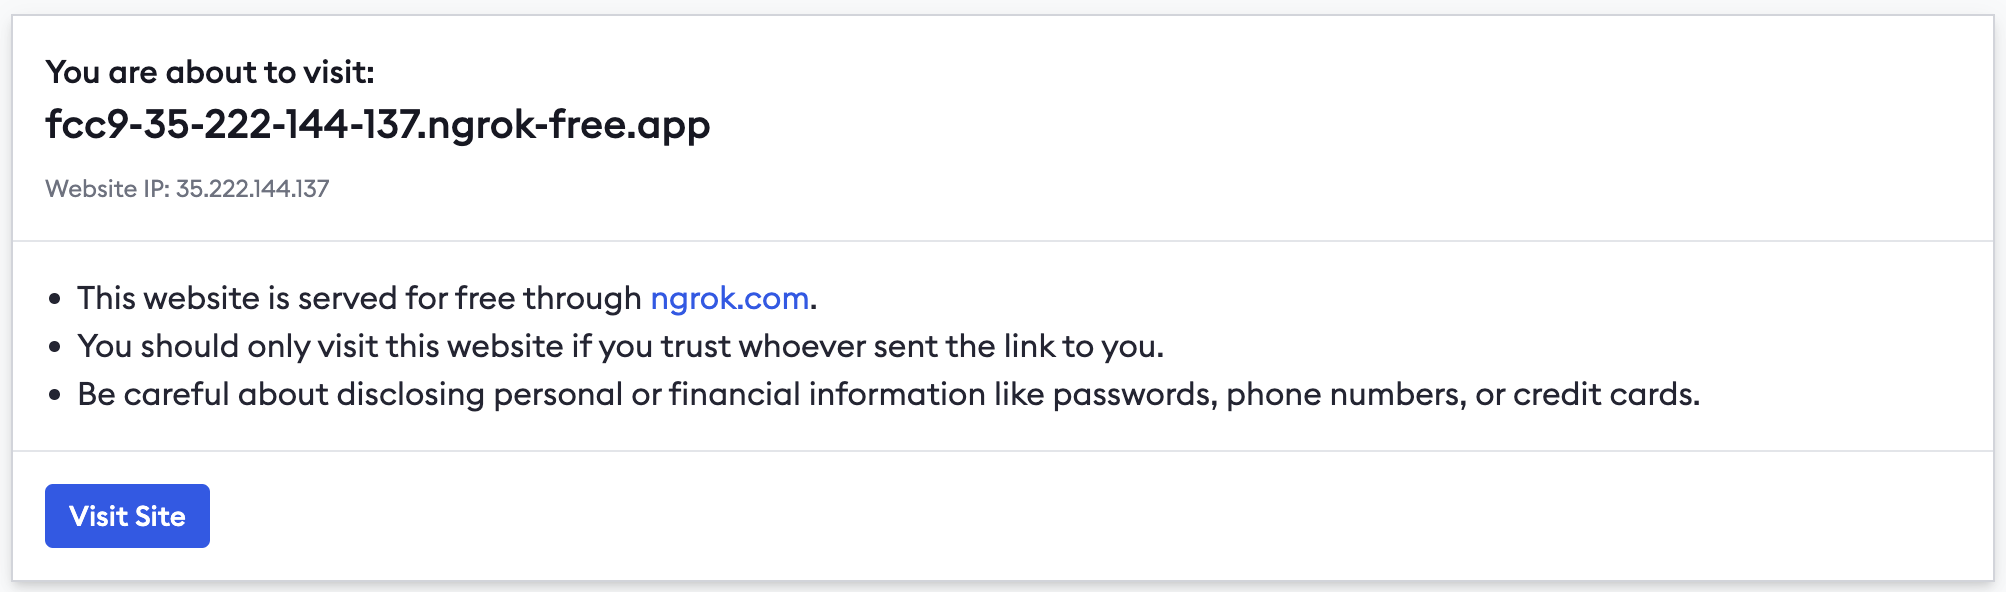

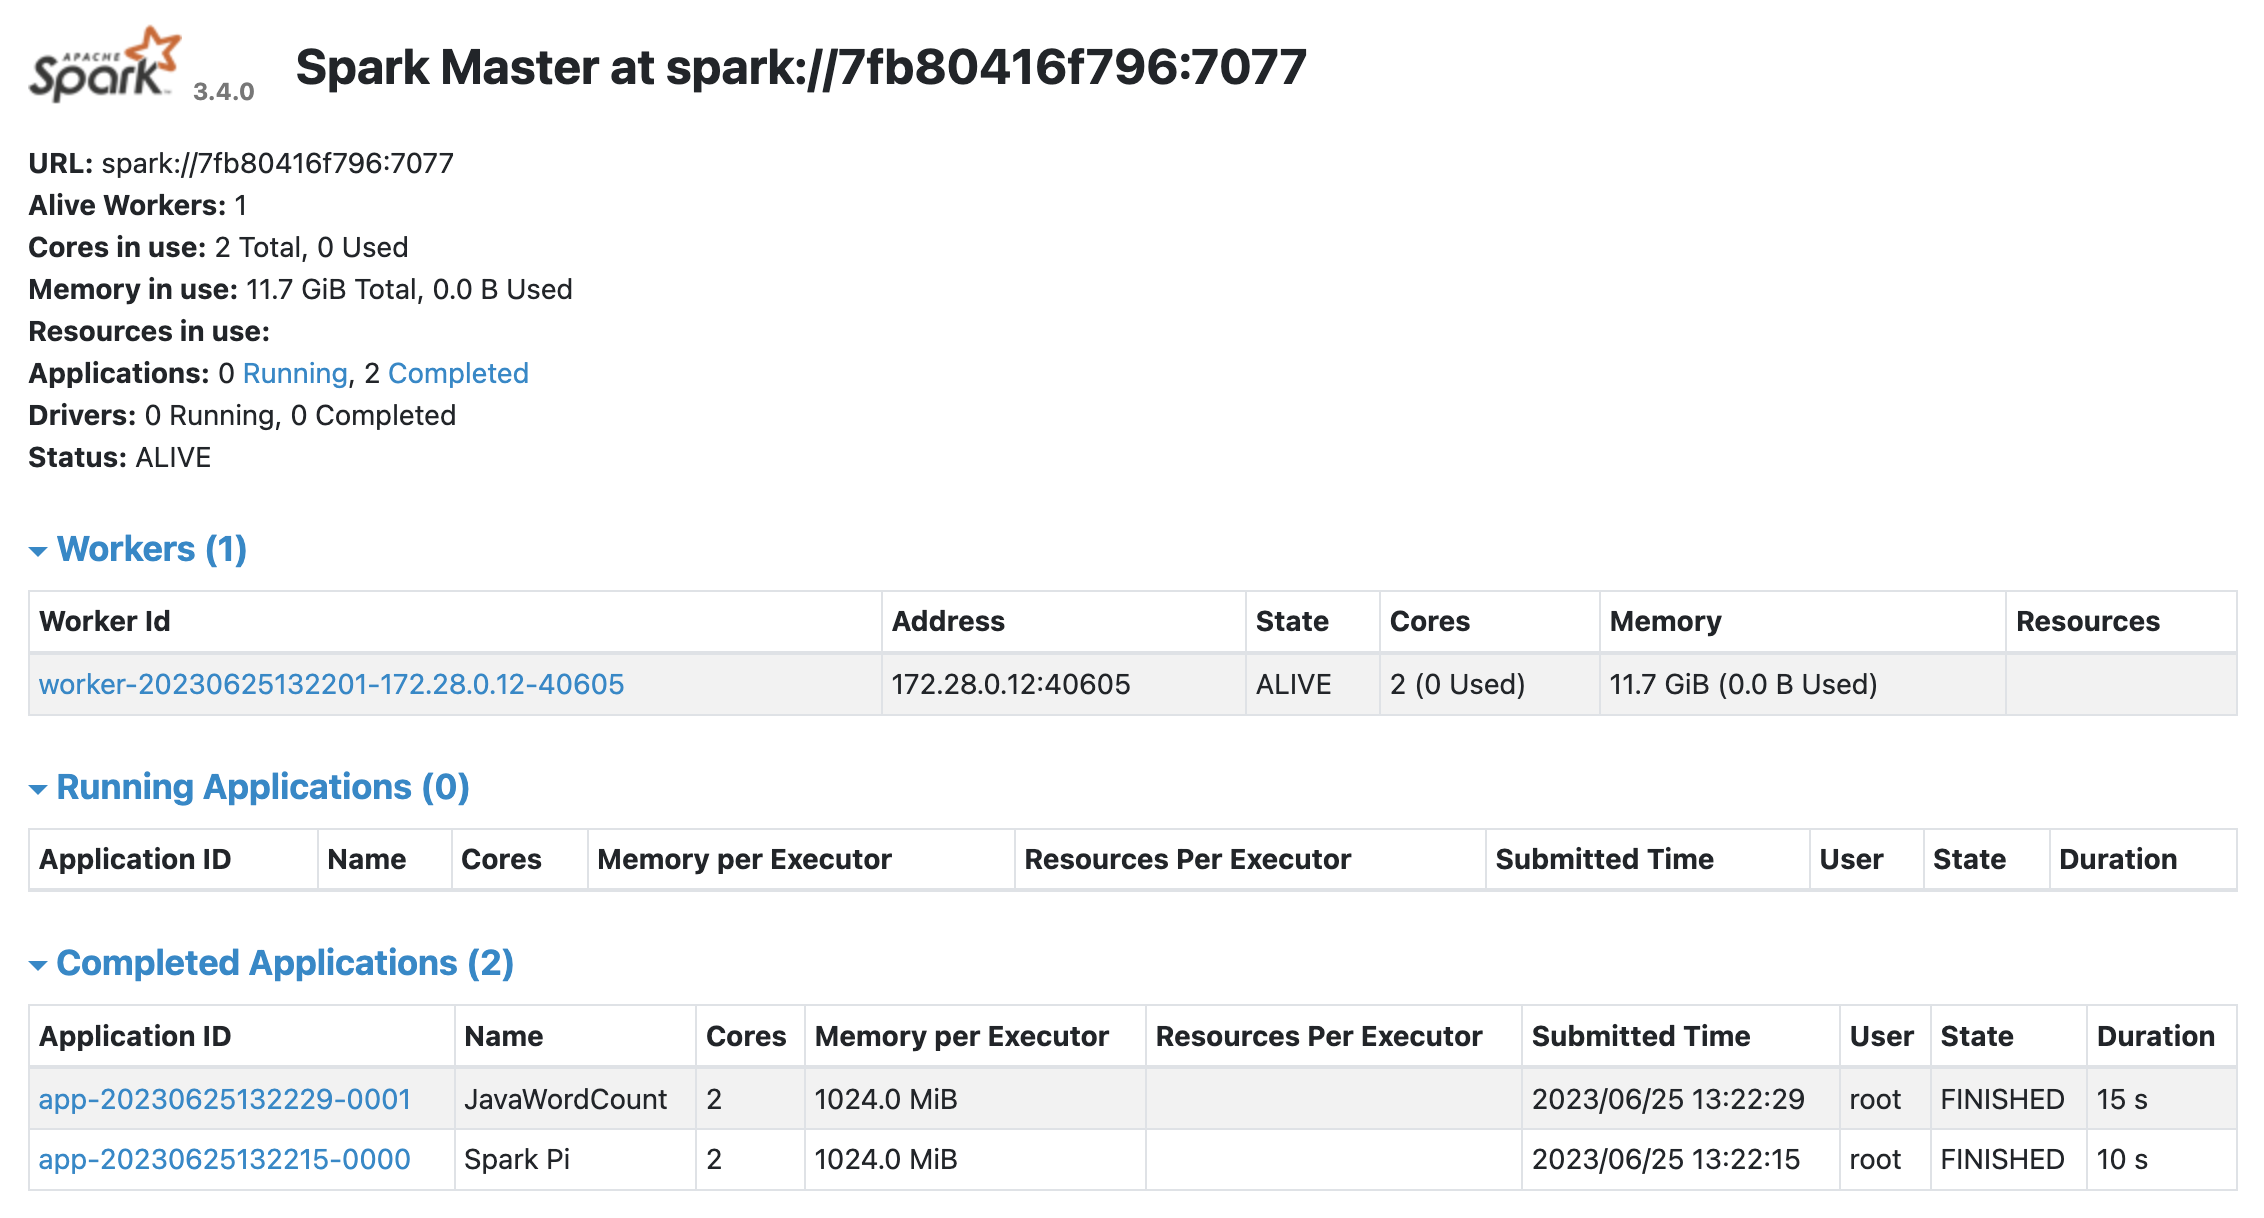

### Spark History Server

The Spark History Server is available at:

In [9]:
if IN_COLAB:
    from google.colab.output import eval_js
    print(eval_js( "google.colab.kernel.proxyPort(" + str(18080) + ")" ))

With ngrok:

In [10]:
if NGROK:
  # Open a ngrok tunnel to the HTTP server
  public_url = ngrok.connect(18080).public_url
  print(f'Click on {public_url} to open the Spark Master Web UI')

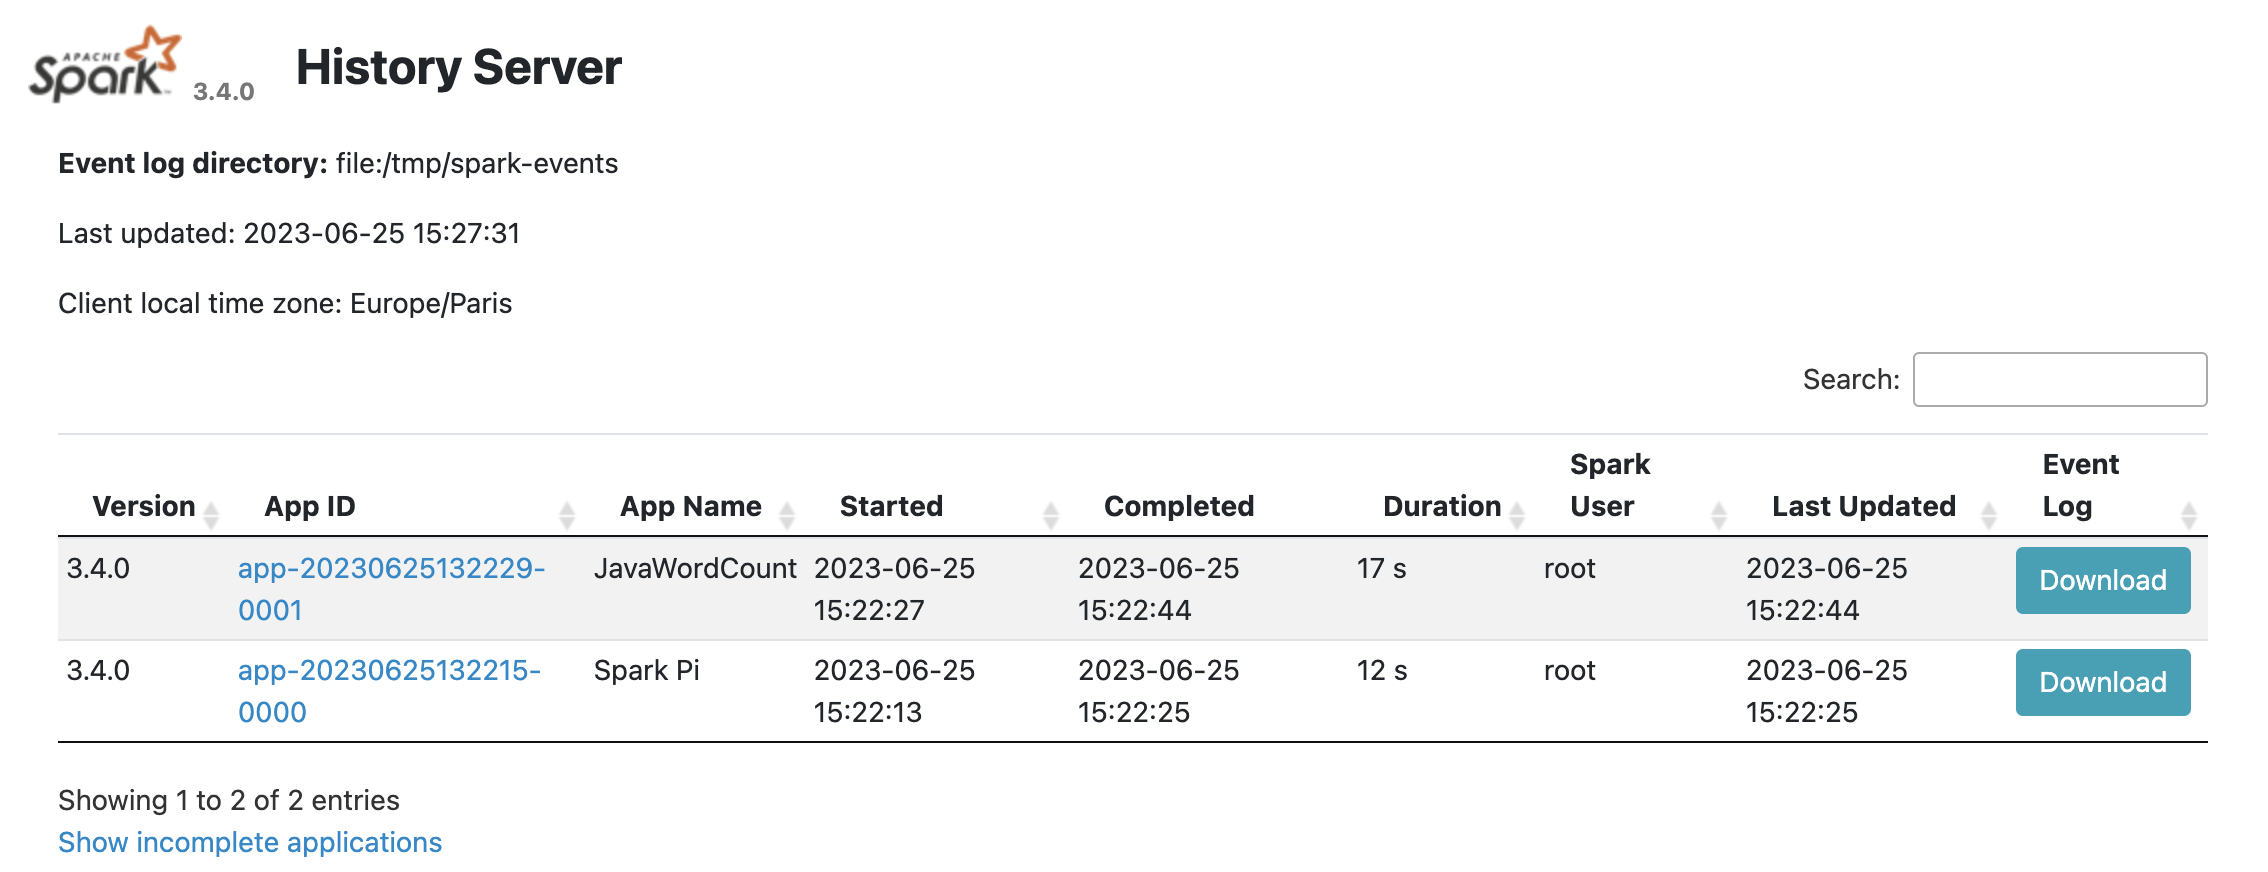

### Logs for the Spark Master

In [11]:
!head -20 $SPARK_HOME/logs/*Master*.out

Spark Command: /opt/hostedtoolcache/Java_Temurin-Hotspot_jdk/11.0.27-6/x64/bin/java -cp /home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/conf/:/home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/jars/* -Xmx1g org.apache.spark.deploy.master.Master --host fv-az813-228.f3ggjusmajuejdvszc5ta12tmg.cx.internal.cloudapp.net --port 7077 --webui-port 8080
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/13 15:21:22 INFO Master: Started daemon with process name: 2944@fv-az813-228
25/07/13 15:21:22 INFO SignalUtils: Registering signal handler for TERM
25/07/13 15:21:22 INFO SignalUtils: Registering signal handler for HUP
25/07/13 15:21:22 INFO SignalUtils: Registering signal handler for INT
25/07/13 15:21:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/13 15:21:22 INFO SecurityManager: Changing view acls to: runner
25/07/13 15:21:22 INFO SecurityManager: C

### Logs for the Spark Worker

In [12]:
!head -20 $SPARK_HOME/logs/*Worker*.out

Spark Command: /opt/hostedtoolcache/Java_Temurin-Hotspot_jdk/11.0.27-6/x64/bin/java -cp /home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/conf/:/home/runner/work/big_data/big_data/spark-3.5.6-bin-hadoop3/jars/* -Xmx1g org.apache.spark.deploy.worker.Worker --webui-port 8081 spark://fv-az813-228:7077
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
25/07/13 15:21:25 INFO Worker: Started daemon with process name: 3030@fv-az813-228
25/07/13 15:21:25 INFO SignalUtils: Registering signal handler for TERM
25/07/13 15:21:25 INFO SignalUtils: Registering signal handler for HUP
25/07/13 15:21:25 INFO SignalUtils: Registering signal handler for INT
25/07/13 15:21:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/07/13 15:21:25 INFO SecurityManager: Changing view acls to: runner
25/07/13 15:21:25 INFO SecurityManager: Changing modify acls to: runner
25/07/13 15:21:25 INFO Secu

### Spark events (used by History Server)

In [13]:
!head -20 /tmp/spark-events/*

==> /tmp/spark-events/app-20250713152131-0000 <==
{"Event":"SparkListenerLogStart","Spark Version":"3.5.6"}
{"Event":"SparkListenerResourceProfileAdded","Resource Profile Id":0,"Executor Resource Requests":{"memory":{"Resource Name":"memory","Amount":1024,"Discovery Script":"","Vendor":""},"offHeap":{"Resource Name":"offHeap","Amount":0,"Discovery Script":"","Vendor":""}},"Task Resource Requests":{"cpus":{"Resource Name":"cpus","Amount":1.0}}}
{"Event":"SparkListenerBlockManagerAdded","Block Manager ID":{"Executor ID":"driver","Host":"fv-az813-228.f3ggjusmajuejdvszc5ta12tmg.cx.internal.cloudapp.net","Port":35443},"Maximum Memory":455501414,"Timestamp":1752420091654,"Maximum Onheap Memory":455501414,"Maximum Offheap Memory":0}
{"Event":"SparkListenerEnvironmentUpdate","JVM Information":{"Java Home":"/usr/lib/jvm/temurin-11-jdk-amd64","Java Version":"11.0.27 (Eclipse Adoptium)","Scala Version":"version 2.12.18"},"Spark Properties":{"spark.executor.extraJavaOptions":"-Djava.net.preferIPv6

### Spark configuration

To customize Spark use the configuration templates in `$SPARK_HOME/conf` (remove the template extension).


In [14]:
!ls -al $SPARK_HOME/conf

total 44
drwxr-xr-x  2 runner docker 4096 May 23 06:49 .
drwxr-xr-x 15 runner docker 4096 Jul 13 15:21 ..
-rw-r--r--  1 runner docker 1105 May 23 06:49 fairscheduler.xml.template
-rw-r--r--  1 runner docker 3350 May 23 06:49 log4j2.properties.template
-rw-r--r--  1 runner docker 9141 May 23 06:49 metrics.properties.template
-rw-r--r--  1 runner docker 1292 May 23 06:49 spark-defaults.conf.template
-rwxr-xr-x  1 runner docker 4694 May 23 06:49 spark-env.sh.template
-rw-r--r--  1 runner docker  865 May 23 06:49 workers.template


## Shutdown

Stop all services.

In [15]:
%%bash
$SPARK_HOME/sbin/stop-history-server.sh
$SPARK_HOME/sbin/stop-worker.sh
$SPARK_HOME/sbin/stop-master.sh

stopping org.apache.spark.deploy.history.HistoryServer


stopping org.apache.spark.deploy.worker.Worker


stopping org.apache.spark.deploy.master.Master


Terminate the ngrok processes.

In [16]:
if NGROK:
  ngrok.kill()